# Backtest Of Exiting the Market During a Downtrend MACD Signal

## Import packages

### Import libraries


In [1]:
# Standard library imports
import os      # Operating system interfaces
import sys     # System-specific parameters and functions
import json    # JSON encoder and decoder

# Data manipulation and analysis
import pandas as pd      # DataFrame and data analysis
import numpy as np       # Numerical operations
import openpyxl as px   # Excel file reading and writing
import h5py    # HDF5 file format for storing large datasets
from scipy.io import loadmat # MATLAB file format for loading data

# Plotting and visualization
import matplotlib.pyplot as plt           # Static plotting
import matplotlib.dates as mdates         # Date formatting for matplotlib
import matplotlib.colors as mcolors       # Color utilities for matplotlib for different line series colours
import plotly.graph_objs as go            # Interactive plotting
from IPython.display import display # Display objects in Jupyter notebooks
# Grammar of graphics plotting (ggplot-style)
from plotnine import *                   # Main plotnine API for ggplot-style plotting
from plotnine.scales import scale_x_date # For date scaling on x-axis in plotnine

# Dash web app framework
import dash                              # Dash app framework
from dash import dcc                     # Dash core components
from dash import html                    # Dash HTML components
from dash.dependencies import Input, Output  # Dash callback dependencies

# Warnings control
import warnings  # Warning control
from plotnine.exceptions import PlotnineWarning


# Streamlit web app framework (not used in current code)
import streamlit as st                   # Streamlit app framework


### Import Custom Packages

In [2]:
parent_dir = os.path.join(os.getcwd(),"../src")
sys.path.insert(0, parent_dir)
from stats_utils import sql_queries as sqlq

## Import Data

In [3]:
# import the interday S&P 500 data from the csv file in the data directory
sp500_interday = pd.read_csv("../data/sp500_interday.csv")

In [4]:
# Summarise the data, with datatypes and summary stats shown

print(sp500_interday.info(), "\n", sp500_interday.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6289 entries, 0 to 6288
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   caldt   6289 non-null   object 
 1   vwretd  6289 non-null   float64
 2   spindx  6289 non-null   float64
 3   sprtrn  6289 non-null   float64
dtypes: float64(3), object(1)
memory usage: 196.7+ KB
None 
             vwretd       spindx       sprtrn
count  6289.000000  6289.000000  6289.000000
mean      0.000371  2112.015173     0.000295
std       0.012187  1243.314916     0.012214
min      -0.118970   676.530000    -0.119841
25%      -0.004736  1200.820000    -0.004796
50%       0.000675  1491.560000     0.000597
75%       0.006026  2748.930000     0.005926
max       0.115133  6090.270000     0.115800


## Clean The Data

### Change Column Names

In [5]:
# Rename the columns to time, val_wgt_ret_w_div, level, base_return, in that order
sp500_interday.columns = ['time', 'val_wgt_ret_w_div', 'level', 'base_return']


### Clean the date column

In [6]:
# Convert the time column to datetime format
sp500_interday['time'] = pd.to_datetime(sp500_interday['time'], format='%d/%m/%Y', errors='coerce')

# Add a time_label column for plotting, which takes the year, month and day in YY-MM-DD format
sp500_interday['time_label'] = sp500_interday['time'].dt.strftime('%y-%m-%d')

# filter out only the period of interest, from 2020-01-01 to 2023-10-01
#sp500_interday = sp500_interday[(sp500_interday['time'] >= '2020-01-01') & (sp500_interday['time'] <= '2023-10-01')]



In [7]:
sp500_interday

,time,val_wgt_ret_w_div,level,base_return,time_label
0,2000-01-03,-0.009372,1455.22,-0.009549,00-01-03
1,2000-01-04,-0.038439,1399.42,-0.038345,00-01-04
2,2000-01-05,0.000852,1402.11,0.001922,00-01-05
3,2000-01-06,-0.002845,1403.45,0.000956,00-01-06
4,2000-01-07,0.032193,1441.47,0.027090,00-01-07
...,...,...,...,...,...
6284,2024-12-24,0.011335,6040.04,0.011043,24-12-24
6285,2024-12-26,-0.000392,6037.59,-0.000406,24-12-26
6286,2024-12-27,-0.011109,5970.84,-0.011056,24-12-27
6287,2024-12-30,-0.010782,5906.94,-0.010702,24-12-30


## Add new columns

In [8]:
def get_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate returns and technical indicators for the given DataFrame.
    Args:
        df (pd.DataFrame): DataFrame containing stock data with 'open' and 'close' columns.
    Returns:
        pd.DataFrame: DataFrame with additional columns for returns and technical indicators.
    """     
    # Calculate the inter-day returns in logs
    df.loc[1:, 'day_return'] = np.log(df['level'].values[1:] / df['level'].values[:-1])

    # Calclulate the inter-day returns in discrete returns
    #df['day_return'] = df['level'].pct_change()

    # Add a 'total_day_return' column which is the cumulative return under log returns
    df['total_day_return'] = df['day_return'].cumsum()
    # convert to an effective total return as if it were discrete returns
    df['total_day_return'] = np.exp(df['total_day_return']) - 1

    # Add a 'total_day_return' column which is the cumulative return under discrete returns
    #df['total_day_return'] = (1 + df['day_return']).cumprod() - 1

    # Add a total_base_return column which is the cumulative return under base returns discrete returns
    df['total_base_return'] = (1+df['base_return']).cumprod() - 1

    # Add a 'total_val_wgt_ret_w_div' column which is the cumulative return under volume weighted returns with dividends
    df['total_val_wgt_ret_w_div'] = (1 + df['val_wgt_ret_w_div']).cumprod() - 1


    return df

sp500_interday = get_returns(sp500_interday)




### Save Out to Excel File for Processing

In [9]:
# create a copy of the sp500_interday DataFrame for the excel file
sp500_interday_excel = sp500_interday.copy()

# select only the time and day_return columns for the excel file
sp500_interday_excel = sp500_interday_excel.loc[1:,['time', 'day_return']] # don't need the first row as it has NaN values for day_return

# convert the time column to dd-MMM-YYYY format
#sp500_interday_excel['time'] = sp500_interday_excel['time'].dt.strftime('%d-%b-%Y')

# rename to columns to Date and SPY
sp500_interday_excel.columns = ['Date', 'SPY']

# save out to a csv file in the data directory
sp500_interday_excel.to_excel("../data/sp500_interday_returns.xlsx", index=False)

## Visualisations

### Pre-Plotting Cleaning

#### Change Dataframe Format

In [10]:
# Melt the dataframe to long format for plotting
# for each date, we have 1 value each for each of the total returns columns
plot_df = sp500_interday.melt(
    id_vars=['time', 'time_label'],
    value_vars=['total_day_return', 'total_base_return', 'total_val_wgt_ret_w_div'],
    var_name='return_type',
    value_name='return_value'
)

# drop the nan values, which will be for the first day
plot_df = plot_df.dropna(subset=['return_value'])



# Re-format returns as percentages
plot_df['return_value'] = plot_df['return_value'] * 100

plot_df.head()

,time,time_label,return_type,return_value
1,2000-01-04,00-01-04,total_day_return,-3.834472
2,2000-01-05,00-01-05,total_day_return,-3.649620
3,2000-01-06,00-01-06,total_day_return,-3.557538
4,2000-01-07,00-01-07,total_day_return,-0.944874
5,2000-01-10,00-01-10,total_day_return,0.163549


#### Add a Label Mapping for Each Type of Return

In [11]:
# Get the unique return types from the melted DataFrame
return_types = plot_df['return_type'].dropna().unique()

# Create a label mapping that maps the return types to more compact labels
return_type_labels = {
    'total_day_return': 'Total Day Return',
    'total_base_return': 'Total Base Return',
    'total_val_wgt_ret_w_div': 'Total Volume Weighted \n Return with Dividends'
}

#### Add a Colour Mapping for Each type of Return

In [12]:
# Create a mapping for colors for each return_type using a yellow to red gradient




# Use matplotlib's colormap to generate a yellow-to-red spectrum
cmap = plt.get_cmap('autumn')  # yellow to red
colors = [mcolors.to_hex(cmap(i / (len(return_types) - 1))) for i in range(len(return_types))]

# Map each return_type to a color
color_map = dict(zip(return_types, colors))

In [13]:
color_map

{'total_day_return': '#ff0000',
 'total_base_return': '#ff8000',
 'total_val_wgt_ret_w_div': '#ffff00'}

### X Series Labels

In [14]:
# 1. Select relevant columns and remove duplicates
label_df = plot_df[['time', 'time_label']].drop_duplicates().sort_values('time')

# 2. Choose evenly spaced rows to get at most 10 unique ticks
n_ticks = min(10, len(label_df))
step = max(1, len(label_df) // n_ticks)
label_df_filtered = label_df.iloc[::step, :].head(n_ticks)

# 3. Extract breaks and labels
time_breaks = label_df_filtered['time'].tolist()
time_labels = label_df_filtered['time_label'].tolist()

### Plot the Total Return under Log Returns, Base Return, and Volume Weighted Return + dividends

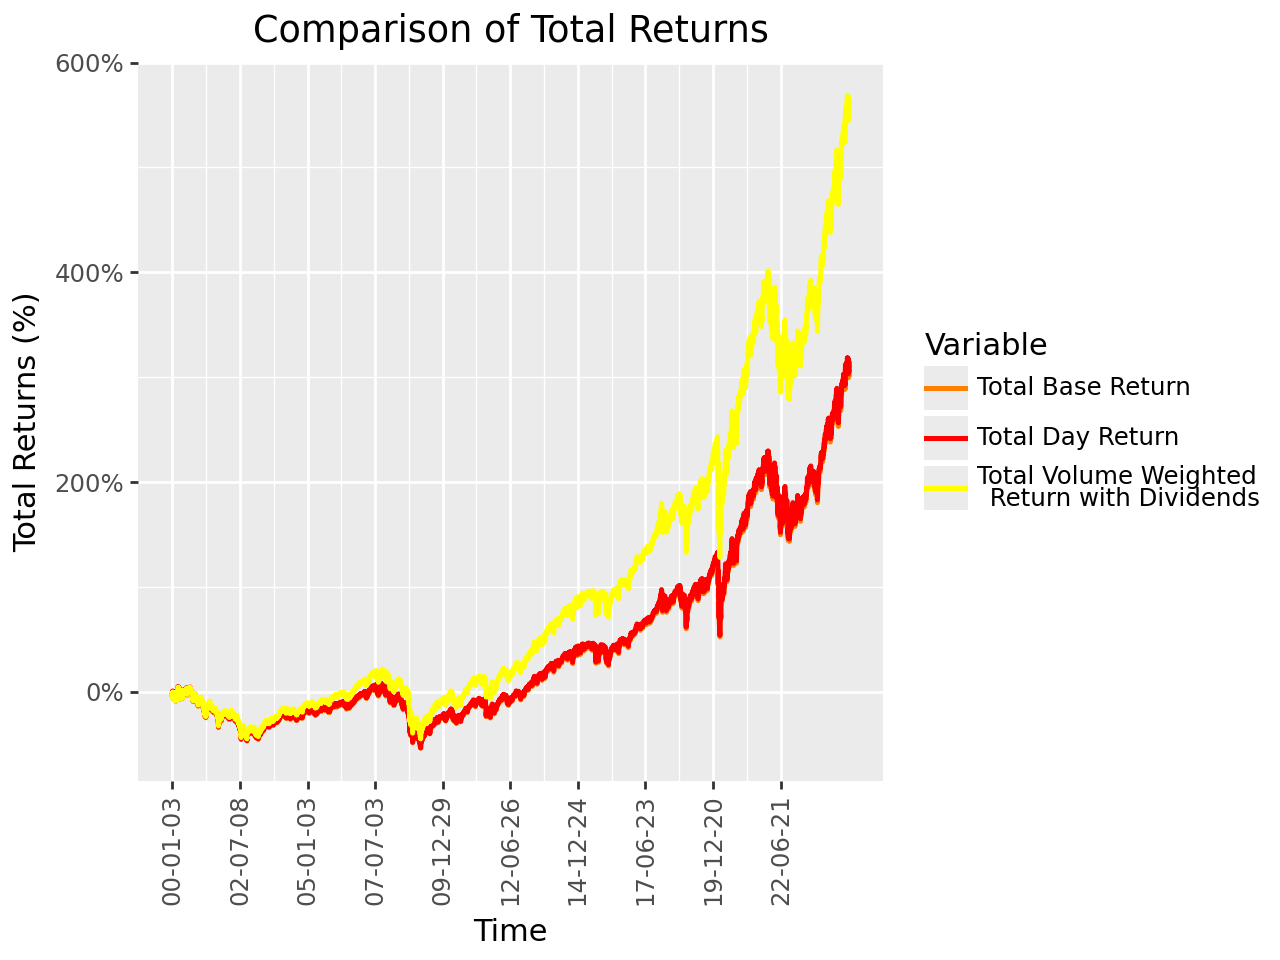

In [15]:
### Plot Each Series On One Plot

def plot_series(
    plot_df=plot_df,
    y='return_value',
    plot_title='Values Over Time',
    y_title='Value',
    display_plot=True
):
    # suppress missing value warnings
    warnings.filterwarnings('ignore', category=PlotnineWarning)

    # Use global color_map, commodity_labels, date_breaks, date_labels
    # Create the plot using plotnine (ggplot-style)
    plot = (
        # Set up the basic plot with aesthetics: x=time, y=selected y, color by return_type
        ggplot(plot_df, aes(x='time', y=y, color='return_type')) +
        # Draw lines for each return_type
        geom_line(size=1) +
        # Manually set colors for each return_type using the color_map and set legend labels
        scale_color_manual(values=color_map, labels=return_type_labels) +
        # Set plot and axis labels
        labs(
            title=plot_title,
            x='Time',
            y=y_title,
            color='Variable'
        ) +
        # Set x-axis breaks and labels for dates
        scale_x_date(breaks=time_breaks, labels=time_labels) +
        # Format y-axis as percentage values
        scale_y_continuous(labels=lambda l: [f"{v:.0f}%" for v in l]) +
        # Customize theme: rotate x labels, move legend, center title
        theme(
            axis_text_x=element_text(rotation=90, ha='center'),
            legend_position='right',
            plot_title=element_text(ha='center')
        ) +
        # Remove linetype guide from legend
        guides(linetype=None)
    )

    # Save plot to file
    fig_path = f"../docs/figures/{plot_title}.png"
    plot.save(fig_path, width=10, height=6, dpi=300)

    # Display plot if requested
    if display_plot:
        display(plot)

    return plot

plot_1 = plot_series(
    plot_df=plot_df,
    y='return_value',
    plot_title='Comparison of Total Returns',
    y_title='Total Returns (%)',
    display_plot=True
)


## Back-Test Volatility Control Strategy

### Import the Forecasted Quantiles Data

In [16]:
# Load the quantiles data from the MATLAB file
#data = loadmat('../data/goog.mat') # load in the data for google

data = loadmat('../data/sp500_interday.mat') # load in the data for S&P 500

q_minus = data['q_minus'] # extract the 3D matrix, or rather, array of 2D matrices for the quantiles
# the 3rd dimension is the quantile index, so q_minus[:,:,0] is the first quantile (the lowest pr), q_minus[:,:,1] is the second quantile, etc.

### Import the Returns Data

In [17]:

# data for just google (default)
#returns = pd.read_excel('../data/GOOG_ret.xlsx')

# data for just S&P 500
returns = pd.read_excel('../data/sp500_interday_returns.xlsx')


In [18]:
returns.dtypes

Date    datetime64[ns]
SPY            float64
dtype: object

#### Initial Cleaning

In [19]:
# change the column names to 'time' and 'return'
returns.columns = ['time', 'return']

# convert the time column to datetime format
returns['time'] = pd.to_datetime(returns['time'], format='%d-%b-%Y', errors='coerce')

# Add a time_label column for plotting, which takes the year, month and day in YY-MM-DD format
returns['time_label'] = returns['time'].dt.strftime('%y-%m-%d')

In [20]:
type(q_minus)

numpy.ndarray

In [21]:
q_minus.shape

(100, 6288, 8)

### Get the Posterior Means of the Quantiles

In [22]:
# Take mean across iterations for *all* quantiles
posterior_means = q_minus.mean(axis=0)   # shape (4033, 8)

# Wrap in DataFrame
posterior_means_df = pd.DataFrame(
    posterior_means,
    columns=[f"q_{i+1}" for i in range(posterior_means.shape[1])]
)

print(posterior_means_df.head())

        q_1       q_2       q_3       q_4       q_5       q_6       q_7  \
0 -0.008779 -0.018783 -0.028739 -0.062455 -0.121501 -0.146185 -0.151183   
1 -0.008211 -0.017564 -0.026859 -0.057305 -0.111064 -0.134362 -0.140002   
2 -0.007145 -0.015367 -0.023458 -0.050342 -0.098598 -0.119772 -0.124997   
3 -0.006209 -0.013431 -0.020467 -0.044200 -0.087508 -0.106739 -0.111562   
4 -0.005789 -0.012516 -0.019070 -0.040493 -0.079884 -0.097941 -0.103076   

        q_8  
0 -0.181472  
1 -0.169203  
2 -0.151663  
3 -0.135892  
4 -0.126328  


### Merge the Quantiles with the Returns Data

Here, we also select only a specified date range for easier visualisation

In [23]:
# merge with the returns Dataframe
merged_returns = returns.merge(posterior_means_df, left_index=True, right_index=True)

# # filter out the first 100 observations
merged_returns = merged_returns.iloc[100:]


# reverse the order of the non-time columns so that we go from q_8 to q_1 and then return
#merged_returns = merged_returns[['time', 'time_label'] + [f'q_{i+1}' for i in range(7, -1, -1)] + ['return']]

In [24]:
merged_returns.head()

,time,return,time_label,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8
100,2000-05-26,-0.002537,00-05-26,-0.001793,-0.003731,-0.005828,-0.008308,-0.011491,-0.015406,-0.020498,-0.028028
101,2000-05-30,0.031733,00-05-30,-0.001627,-0.003404,-0.005317,-0.007601,-0.010564,-0.014232,-0.019038,-0.026127
102,2000-05-31,-0.001301,00-05-31,-0.001905,-0.003951,-0.006172,-0.008783,-0.012111,-0.016189,-0.021468,-0.029287
103,2000-06-01,0.019663,00-06-01,-0.001705,-0.003558,-0.005559,-0.007936,-0.011005,-0.014791,-0.019736,-0.027038
104,2000-06-02,0.019446,00-06-02,-0.001791,-0.003727,-0.005822,-0.008300,-0.011480,-0.015393,-0.020482,-0.028007


### Calculate Target Weights Based on Forecast Quantiles

Consider a simple representative portfolio with some weight in a market index and some weight in cash. We back-test the performance of index strategies where the index portfolio is rebalanced daily, and the weights are adjusted based on the forecasted quantiles of returns.

For comparability to volatility targeting, we similarly dynamically adjust the weights in the market index so as to maintain target forecasted quantiles. When the forecasted lower/left tail quantiles of returns on the carrying value of the portfolio are below the target/are more negative, we reduce the weights in the market index until the forecasted quantile of returns returns to target. Likewise, when the forecasted upper/right tail quantiles are above the target, we increase the weights in the market index.

By setting a target step-ahead quantile at probability level p% to not fall below a certain level, r%, we effectively aim for the portfolio to have no more than a p% probability of seeing a drawdown of k% or more over the next step-ahead period. This can then aggregate to a longer period, such as over the next quarter or year. For reference, if we set p = 5.56%, and r = 0.63%, then we are aiming for the portfolio to have no more than a 5.56% probability of seeing a drawdown of 0.63% or more over the next step-ahead period, and in turn, no more than a 5.56% probability of seeing a drawdown of 5% or more over the next quarter.

In [25]:
# Set maximum drawdown/quantile target
r = 0.0063

# Note that the target probability level will be given by the quantile forecast that we compare this to, in this case q_8

# define a function calc_targ_weight that calculates the target weight in the market index based on the quantile forecast
# this takes as input a the forecast quantile we are comparing and the maximum drawdown/quantile target
def calc_targ_weight(q_forecast: float, r: float, spec: int = 2) -> float:
    """
    Calculate the target weight in the market index based on the quantile forecast.
    
    Args:
        q_forecast (float): The forecasted quantile value.
        r (float): The maximum drawdown/quantile target.
        
    Returns:
        float: The target weight in the market index.
    """
    if spec == 1:
        # For the first specification, the weight is set to 1 when the quantile forecast is above the target
        if q_forecast >= -r:
            w_targ = 1
        else:
            # If the quantile forecast is below the target, we set the weight to 0
            w_targ = 0
        return w_targ
    if spec == 2:
        # For the second specification, the weight changes linearly with the quantile forecast
        w_targ = min(1, (-r / q_forecast))   

    return w_targ





In [26]:
# More efficient - Direct vectorized calculation for spec=2
merged_returns['target_weight'] = np.maximum(np.minimum(1, -r / merged_returns['q_7']),0) # makes sure the weight is between 0 and 1

# OPTION 2: Alternative using pandas clip method (also vectorized)
# merged_returns['w_targ'] = (r / merged_returns['q_8']).clip(upper=1)

# OPTION 3: If you need to handle different specs, use numpy.where for vectorized conditionals
# For spec=1: merged_returns['w_targ'] = np.where(merged_returns['q_8'] >= -r, 1, 0)

# The original apply method (keep for reference but commented out)
# merged_returns['w_targ'] = merged_returns['q_8'].apply(lambda x: calc_targ_weight(x, r, spec=2))

### Calculate 'Actual' Weights to Reflect Trading Delays

We Create a index_weight column that is the target weight column shifted by one row this is to reflect a 1-day trading delay (we only know the target weight at the beginning of the day that follows the last day of the estimation window, because only then do we know the confirmed closing price of the last day).

For liquidity reasons, we only trade once a day, at the end of the day, and so even though we know the target weight at the beginning of the day, we only trade at the end of that day.

In [27]:
# Create a index_weight column that is the target weight column shifted by one row
# this is to reflect a 1-day trading delay (we only know the target weight at the beginning of the day
# that follows the last day of the estimation window, because only then do we know the confirmed closing price of the last day)
# for liquidity reasons, we only trade once a day, at the end of the day, and so even though we know the target weight at
# the beginning of the day, we only trade at the end of the day

merged_returns['index_weight'] = merged_returns['target_weight'].shift(1)

# Now calculate the actual, index returns based on the index weight
merged_returns['index_return'] = merged_returns['return'] * merged_returns['index_weight']




### Calculate Total Returns

Note that this is done over a specified window of one's choosing, by default, we zoom in on the GFC period, but this can be changed by modifying the `start_date` and `end_date` variables.

In [28]:
def calc_total_returns(merged_df, start_date=None, end_date=None, return_df =True):
    """
    Calculate total and index returns for a specified window and filter quantile columns.

    Args:
        merged_df (pd.DataFrame): DataFrame containing returns and quantiles.
        start_date (str or None): Start date for the window (inclusive), format 'YYYY-MM-DD'.
        end_date (str or None): End date for the window (inclusive), format 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: Modified DataFrame with total returns and selected columns.
    """
    # If start_date or end_date is None, use the full DataFrame
    if start_date is None or end_date is None:
        df = merged_df.copy()
    else:
        df = merged_df[(merged_df['time'] >= start_date) & (merged_df['time'] <= end_date)].copy()

    # Add a 'total_return' column which is the cumulative return under log returns for the chosen time window
    return_sum = df['return'].cumsum()
    df['total_return'] = np.exp(return_sum) - 1

    # Calculate the cumulative index return
    index_return_sum = df['index_return'].cumsum()
    df['total_index_return'] = np.exp(index_return_sum) - 1

    # if return_df is True, we want to return the DataFrame with total returns and the weights DataFrame
    if return_df:
        # Drop the first row, as it has NaN values for index_weight and index_return
        df = df.dropna(subset=['index_weight', 'index_return'])

        # Get just the weights columns to a separate DataFrame if needed outside (not returned here)
        weights_df = df[['time', 'time_label', 'target_weight', 'index_weight']].copy()

        # Filter out the q_1, q_2, q_3, q_5 and q_6 columns, and set the desired order of columns
        df = df[['time', 'time_label', 'total_return', 'total_index_return', 'return'] + [f'q_{i}' for i in [1,4,7,8]]]

        # return both the DataFrame with total returns and the weights DataFrame
    
        return df, weights_df
    
    # otherwise, we want to calculate the back-test statistics for the window in question
    else:
        # get the total return over the whole period for the index and the underlying asset (also happens to be an index)
        total_return = df['total_return'].iloc[-1] # the last value in the total_return column
        total_index_return = df['total_index_return'].iloc[-1] # the last value in the total_index_return column

        # Annualize each of these returns under log returns
        # For log returns, the sum of log returns is the total log return over the period.
        # To annualize, multiply the average daily log return by 252, then exponentiate and subtract 1.
        total_return_annualized = np.exp(df['return'].mean() * 252) - 1
        total_index_return_annualized = np.exp(df['index_return'].mean() * 252) - 1
        
        # calculate the annualized volatility of the different returns
        annualized_volatility = df['return'].std() * np.sqrt(252)
        annualized_index_volatility = df['index_return'].std() * np.sqrt(252)

        # calculate the annualized Sharpe ratio for both the total return and the index return
        annualized_sharpe_ratio = total_return_annualized / annualized_volatility
        annualized_index_sharpe_ratio = total_index_return_annualized / annualized_index_volatility

        # return the total returns, annualised returns, annualised volatility, and annualised sharpe ratios
        # Convert np.float64 values to native Python floats for output
        return {
            'total_return': float(total_return),
            'total_index_return': float(total_index_return),
            'total_return_annualized': float(total_return_annualized),
            'total_index_return_annualized': float(total_index_return_annualized),
            'annualized_volatility': float(annualized_volatility),
            'annualized_index_volatility': float(annualized_index_volatility),
            'annualized_sharpe_ratio': float(annualized_sharpe_ratio),
            'annualized_index_sharpe_ratio': float(annualized_index_sharpe_ratio)
        }




In [29]:
sum_stats_1 = calc_total_returns(merged_returns, start_date='2008-05-01', end_date='2009-05-01', return_df=False)
sum_stats_1

{'total_return': -0.3666813415223831,
 'total_index_return': -0.11734623892986051,
 'total_return_annualized': -0.36553687670036605,
 'total_index_return_annualized': -0.11691065778129295,
 'annualized_volatility': 0.44816146946685737,
 'annualized_index_volatility': 0.09570556384360016,
 'annualized_sharpe_ratio': -0.815636554242864,
 'annualized_index_sharpe_ratio': -1.2215659475382818}

## Calculate Performance Summary Statistics for Each Strategy

In [30]:
# Initialise an empty dataframe to store the summary statistics for each time window
summary_stats = pd.DataFrame(columns=[
    'start_date', 'end_date', 'total_return', 'total_index_return',
    'total_return_annualized', 'total_index_return_annualized',
    'annualized_volatility', 'annualized_index_volatility',
    'annualized_sharpe_ratio', 'annualized_index_sharpe_ratio'
])
# Define the time windows for backtesting as the start and end of each year for the
#  last 10 years up to the last available date in the dataset
last_date = merged_returns['time'].max().date()  # Get the last date in the dataset
first_date = merged_returns['time'].min().date()  # Get the first date in the dataset
# Start from 20 years ago, or as far as the data goes back, whichever is later
start_year = max(last_date.year - 20, first_date.year)


# Collect results in a list of dicts, then create DataFrame at the end
stats_list = []
for year in range(start_year, last_date.year + 1):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    stats = calc_total_returns(merged_returns, start_date=start_date, end_date=end_date, return_df=False)
    stats_list.append({
        'start_date': start_date,
        'end_date': end_date,
        **stats
    })

# Add YTD (Year-To-Date) window
ytd_start = f"{last_date.year}-01-01"
ytd_end = str(last_date)
stats = calc_total_returns(merged_returns, start_date=ytd_start, end_date=ytd_end, return_df=False)
stats_list.append({
    'start_date': ytd_start,
    'end_date': ytd_end,
    **stats
})

# Add last 3, 5, and 10 year windows (up to and including last_date)
for window in [3, 5, 10]:
    window_start_year = max(last_date.year - window + 1, first_date.year)
    window_start = f"{window_start_year}-01-01"
    window_end = str(last_date)
    stats = calc_total_returns(merged_returns, start_date=window_start, end_date=window_end, return_df=False)
    stats_list.append({
        'start_date': window_start,
        'end_date': window_end,
        **stats
    })

# Convert the list of dicts to a DataFrame
summary_stats = pd.DataFrame(stats_list)
summary_stats = summary_stats.round(4)  # Round to 4 decimal places for better readability

# Save out to an excel file in the data directory
summary_stats.to_excel("../data/summary_stats.xlsx", index=False)

# Display the summary statistics DataFrame

display(summary_stats.head())



,start_date,end_date,total_return,total_index_return,total_return_annualized,total_index_return_annualized,annualized_volatility,annualized_index_volatility,annualized_sharpe_ratio,annualized_index_sharpe_ratio
0,2004-01-01,2004-12-31,0.0899,0.0464,0.0899,0.0464,0.1109,0.0741,0.8107,0.6258
1,2005-01-01,2005-12-31,0.0300,-0.0024,0.0300,-0.0024,0.1028,0.0709,0.2918,-0.0334
2,2006-01-01,2006-12-31,0.1362,0.1078,0.1368,0.1083,0.1003,0.0723,1.3641,1.4984
3,2007-01-01,2007-12-31,0.0353,0.0154,0.0354,0.0154,0.1602,0.0877,0.2212,0.1758
4,2008-01-01,2008-12-31,-0.3849,-0.1335,-0.3837,-0.1330,0.4102,0.0937,-0.9354,-1.4189


In [31]:
# get the total returns for the specified window
merged_returns_1, weights_df_1 = calc_total_returns(merged_returns, start_date='2008-05-01', end_date='2009-05-01')



In [32]:
weights_df_1.head()

,time,time_label,target_weight,index_weight
2092,2008-05-01,08-05-01,0.553955,0.537926
2093,2008-05-02,08-05-02,0.497596,0.553955
2094,2008-05-05,08-05-05,0.526190,0.497596
2095,2008-05-06,08-05-06,0.538746,0.526190
2096,2008-05-07,08-05-07,0.538664,0.538746


In [33]:
merged_returns_1.head()

,time,time_label,total_return,total_index_return,return,q_1,q_4,q_7,q_8
2092,2008-05-01,08-05-01,0.017141,0.009184,0.016995,-0.000907,-0.004354,-0.011373,-0.015868
2093,2008-05-02,08-05-02,0.020432,0.010992,0.003230,-0.001061,-0.005003,-0.012661,-0.017530
2094,2008-05-05,08-05-05,0.015806,0.008708,-0.004544,-0.000987,-0.004684,-0.011973,-0.016626
2095,2008-05-06,08-05-06,0.023578,0.012763,0.007623,-0.000961,-0.004567,-0.011694,-0.016252
2096,2008-05-07,08-05-07,0.005038,0.002838,-0.018280,-0.000967,-0.004586,-0.011696,-0.016243


## Visualisation

In [34]:
# Melt the dataframe to long format for plotting
# Use all columns except 'time' as value_vars
plot_df_1 = merged_returns_1.melt(
    id_vars=['time', 'time_label'],
    var_name='return_type',
    value_name='return_value'
)



In [35]:
plot_df_1.head()

,time,time_label,return_type,return_value
0,2008-05-01,08-05-01,total_return,0.017141
1,2008-05-02,08-05-02,total_return,0.020432
2,2008-05-05,08-05-05,total_return,0.015806
3,2008-05-06,08-05-06,total_return,0.023578
4,2008-05-07,08-05-07,total_return,0.005038


#### Add a Label Mapping for Each Type of Return

In [36]:
# Get the unique return types from the melted DataFrame
return_types = plot_df_1['return_type'].dropna().unique()

# Create a label mapping that maps the return types to more compact labels
# Initialize an empty dictionary for return type labels
return_type_labels = {}
# Loop through each unique return type
for rt in return_types:
    # If the return type is 'return', label as 'Returns'
    if rt == 'return':
        return_type_labels[rt] = 'Returns'
    # If the return type is 'total_return', label as 'Total Return'
    elif rt == 'total_return':
        return_type_labels[rt] = 'Total Return'
    # If the return type is 'total_index_return', label as 'Total Index Return'
    elif rt == 'total_index_return':
        return_type_labels[rt] = 'Total Index Return'
    # If the return type starts with 'q_', replace with 'Q' (e.g., 'q_1' -> 'Q1')
    elif rt.startswith('q_'):
        return_type_labels[rt] = rt.replace('q_', 'Q')
    # Otherwise, use the return type as the label
    else:
        return_type_labels[rt] = rt

#### Add a Linetype Mapping for Each Type of Return

In [37]:
# Map each return type to dashed type by default
linetype_map = {rt: 'solid' for rt in return_types}

# Change linetype in linetype map to solid for any key containing 'return'
for key in linetype_map:
    if 'return' in str(key):
        linetype_map[key] = 'solid'

In [38]:
linetype_map

{'total_return': 'solid',
 'total_index_return': 'solid',
 'return': 'solid',
 'q_1': 'solid',
 'q_4': 'solid',
 'q_7': 'solid',
 'q_8': 'solid'}

In [39]:
# Create a transparency/alpha mapping
alpha_map = {}
# Loop through each return type and assign an alpha (transparency) value
for i, rt in enumerate(return_types):
    # Lower alpha for 'return' (raw returns)
    if rt == 'return':
        alpha_map[rt] = 0.3
    # Medium alpha for 'total_return' (cumulative returns)
    elif '_return' in str(rt):
        alpha_map[rt] = 0.8
    # Gradually decreasing alpha for quantile series (q_*)
    elif rt.startswith('q_'):
        alpha_map[rt] = 0.9 - 0.05 * i
    # Default alpha for any other types
    else:
        alpha_map[rt] = 0.3

In [40]:
alpha_map

{'total_return': 0.8,
 'total_index_return': 0.8,
 'return': 0.3,
 'q_1': 0.75,
 'q_4': 0.7,
 'q_7': 0.65,
 'q_8': 0.6}

#### Add a Colour Mapping for Each type of Return

In [41]:
#### Add a Colour Mapping for Each type of Return
# Create a mapping for colors for each return_type using a yellow to red gradient

# Use matplotlib's colormap to generate a yellow-to-red spectrum
cmap = plt.get_cmap('autumn_r')  # red to yellow
colors = [mcolors.to_hex(cmap(i / (len(return_types) - 1))) for i in range(len(return_types))]

# Map each return_type to a color
color_map = dict(zip(return_types, colors))

# change the color for 'return' to black
color_map['return'] = 'black'

# change the color for 'total_return' to green
color_map['total_return'] = 'lightgreen'

# change the color for total_index_return to dark green
color_map['total_index_return'] = 'green'

In [42]:
color_map

{'total_return': 'lightgreen',
 'total_index_return': 'green',
 'return': 'black',
 'q_1': '#ff7f00',
 'q_4': '#ff5500',
 'q_7': '#ff2a00',
 'q_8': '#ff0000'}

### X Series Labels

In [43]:

def gen_x_labels(plot_df, n_ticks=10):
    """
    Generate evenly spaced x-axis breaks and labels for plotting.

    Args:
        plot_df (pd.DataFrame): DataFrame containing 'time' and 'time_label' columns.
        n_ticks (int): Maximum number of ticks/labels to generate.

    Returns:
        tuple: (time_breaks, time_labels)
    """
    # Select only the 'time' and 'time_label' columns, remove duplicates, and sort by time
    label_df = plot_df[['time', 'time_label']].drop_duplicates().sort_values('time')
    # Ensure we do not request more ticks than available unique dates
    n_ticks = min(n_ticks, len(label_df))
    # Calculate step size to evenly space the ticks
    step = max(1, len(label_df) // n_ticks)
    # Select every 'step'-th row to get evenly spaced ticks, up to n_ticks
    label_df_filtered = label_df.iloc[::step, :].head(n_ticks)
    # Extract the list of datetime breaks for the x-axis
    time_breaks = label_df_filtered['time'].tolist()
    # Extract the corresponding string labels for the x-axis
    time_labels = label_df_filtered['time_label'].tolist()
    return time_breaks, time_labels



In [44]:
# filter out the rows where return_type is 'return'
#plot_df = plot_df[plot_df['return_type'] != 'return']


### Plot the Returns of the Target Weights Strategy During Windows of Interest

In [45]:
def plot_returns(plot_df):
    """
    Create a ggplot object for returns and forecast quantiles.

    Args:
        plot_df (pd.DataFrame): DataFrame in long format with columns ['time', 'time_label', 'return_type', 'return_value'].

    Returns:
        plotnine.ggplot.ggplot: The ggplot object (not displayed).
    """
    # Generate x-axis breaks and labels
    time_breaks, time_labels = gen_x_labels(plot_df)

    # Determine plot title based on return_types present
    return_types = plot_df['return_type'].unique()
    has_return = any(rt == 'return' for rt in return_types)
    has_q = any(str(rt).startswith('q_') and str(rt)[2:].isdigit() for rt in return_types)
    if has_return and has_q:
        plot_title = "Comparison of Returns and Forecast Quantiles"
    else:
        plot_title = "Comparison of Total Returns"

    # Create the plot using plotnine (ggplot-style)
    plot = (
        # Set up the basic plot with aesthetics: x=time, y=return_value, color/linetype/alpha by return_type
        ggplot(plot_df, aes(x='time', y='return_value', color='return_type', linetype='return_type', alpha='return_type')) +
        # Draw lines for each return_type
        geom_line(size=1) +
        # Manually set linetypes, alpha, and colors for each return_type using the mapping dicts
        scale_linetype_manual(values=linetype_map, labels=return_type_labels) +
        scale_alpha_manual(values=alpha_map) +
        scale_color_manual(values=color_map, labels=return_type_labels) +
        # Set plot and axis labels
        labs(
            title=plot_title,
            x='Time',
            y="Returns (%)",
            color='Variable'
        ) +
        # Set x-axis breaks and labels for dates
        scale_x_date(breaks=time_breaks, labels=time_labels) +
        # Format y-axis as percentage values
        scale_y_continuous(labels=lambda l: [f"{v*100:.3f}%" for v in l]) +
        # Customize theme: rotate x labels, move legend, center title, set figure size
        theme(
            axis_text_x=element_text(rotation=90, ha='center'),
            legend_position='right',
            plot_title=element_text(ha='center'),
            figure_size=(12, 6)
        ) +
        # Remove linetype and alpha guides from legend
        guides(linetype=False, alpha=False)
    )
    return plot

plot_1 = plot_returns(plot_df_1)


#### During the GFC

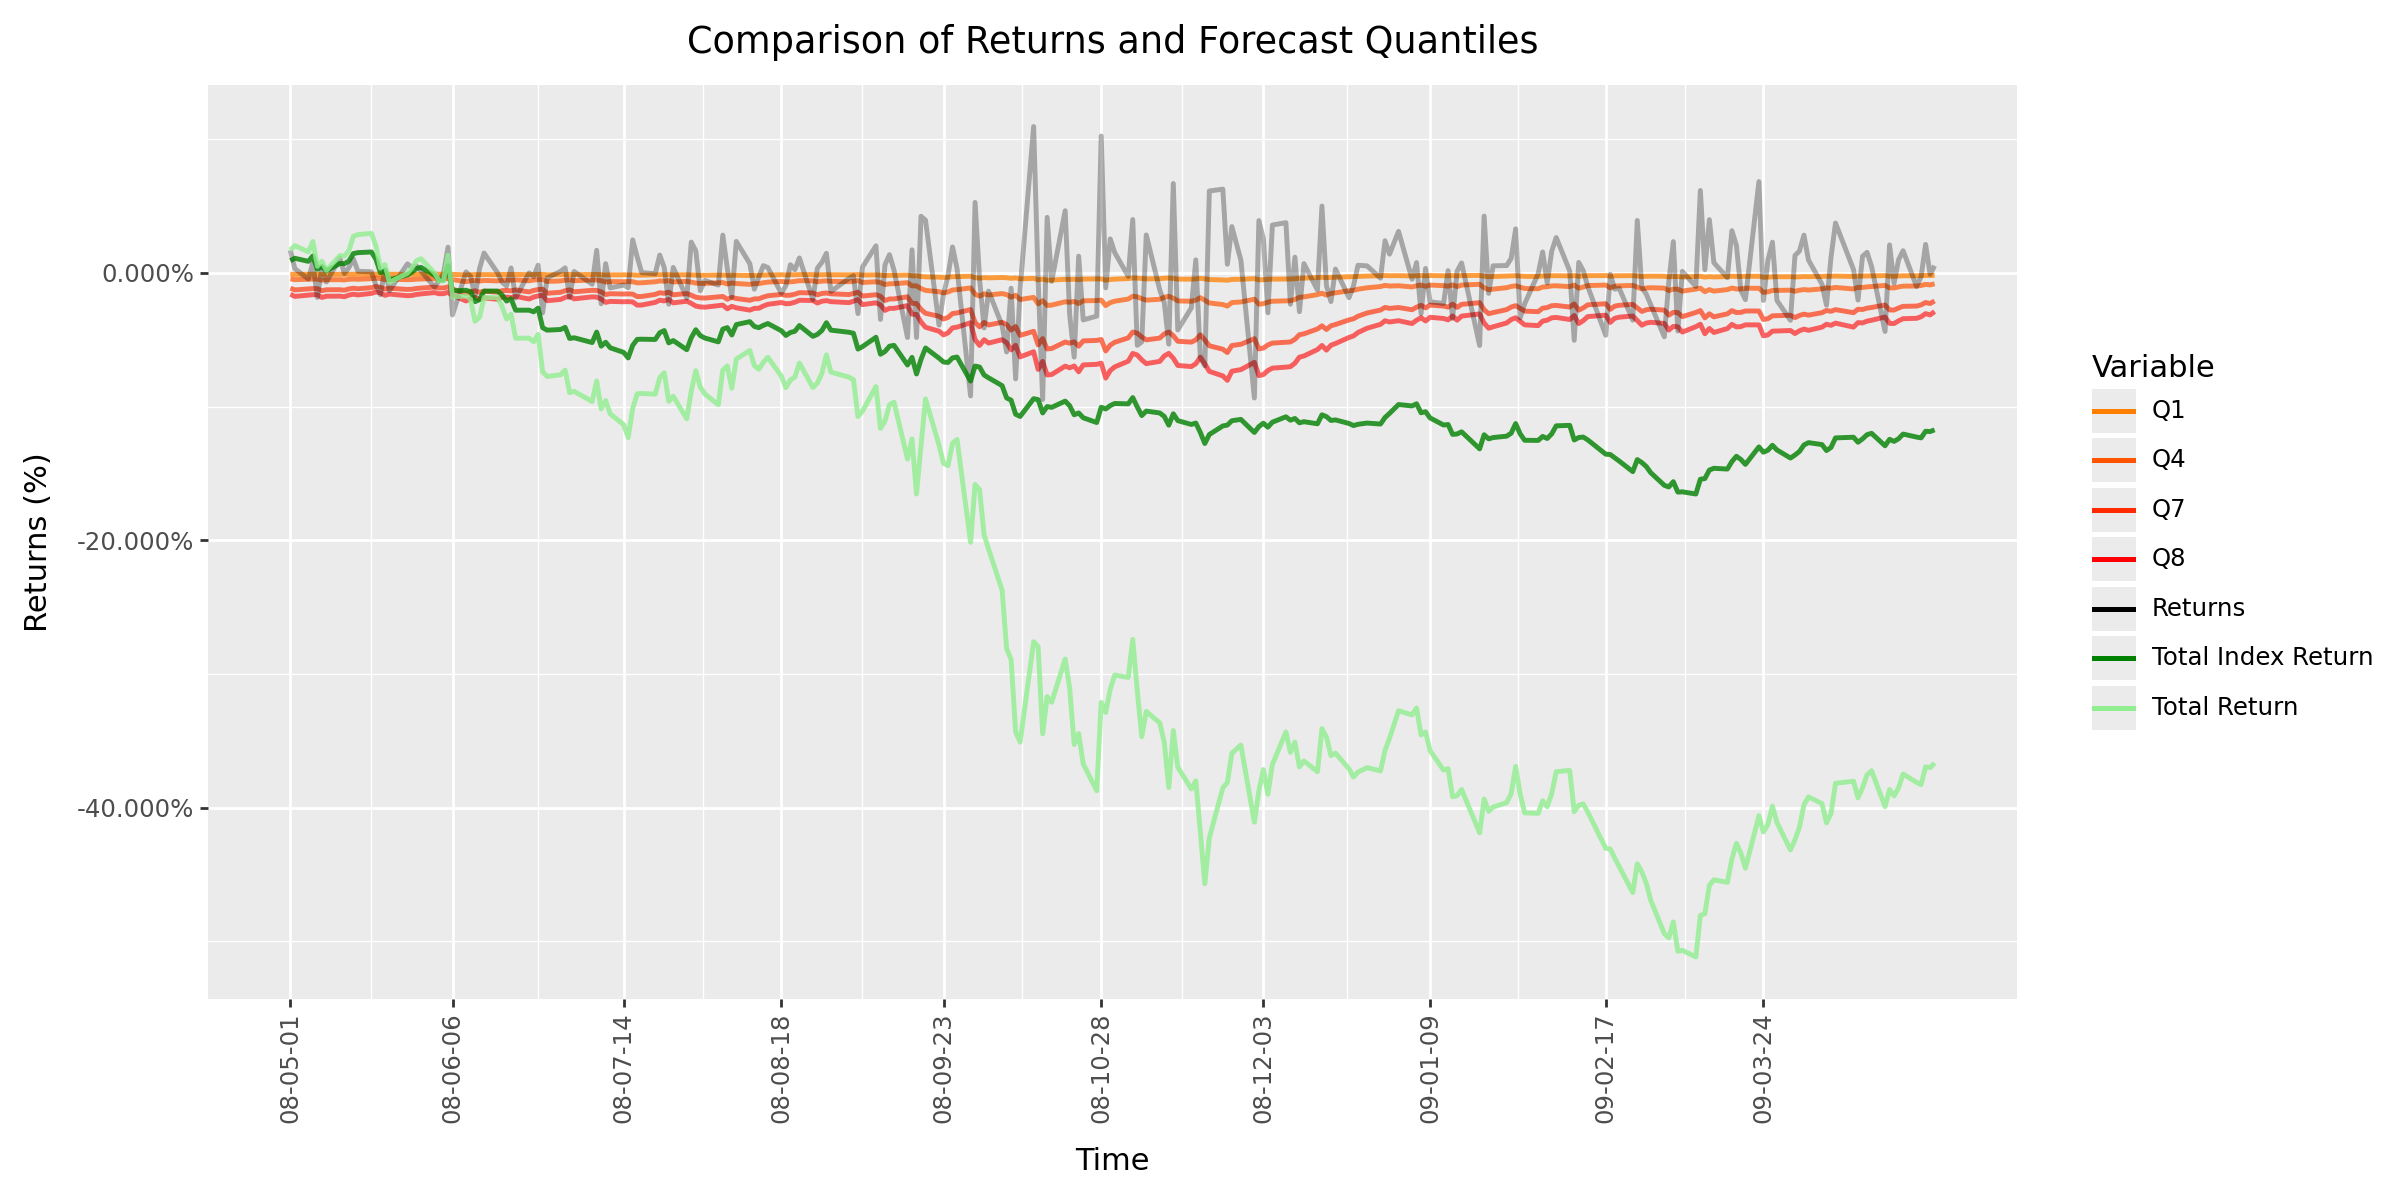

In [46]:
plot_1

#### During the Whole Window of Data

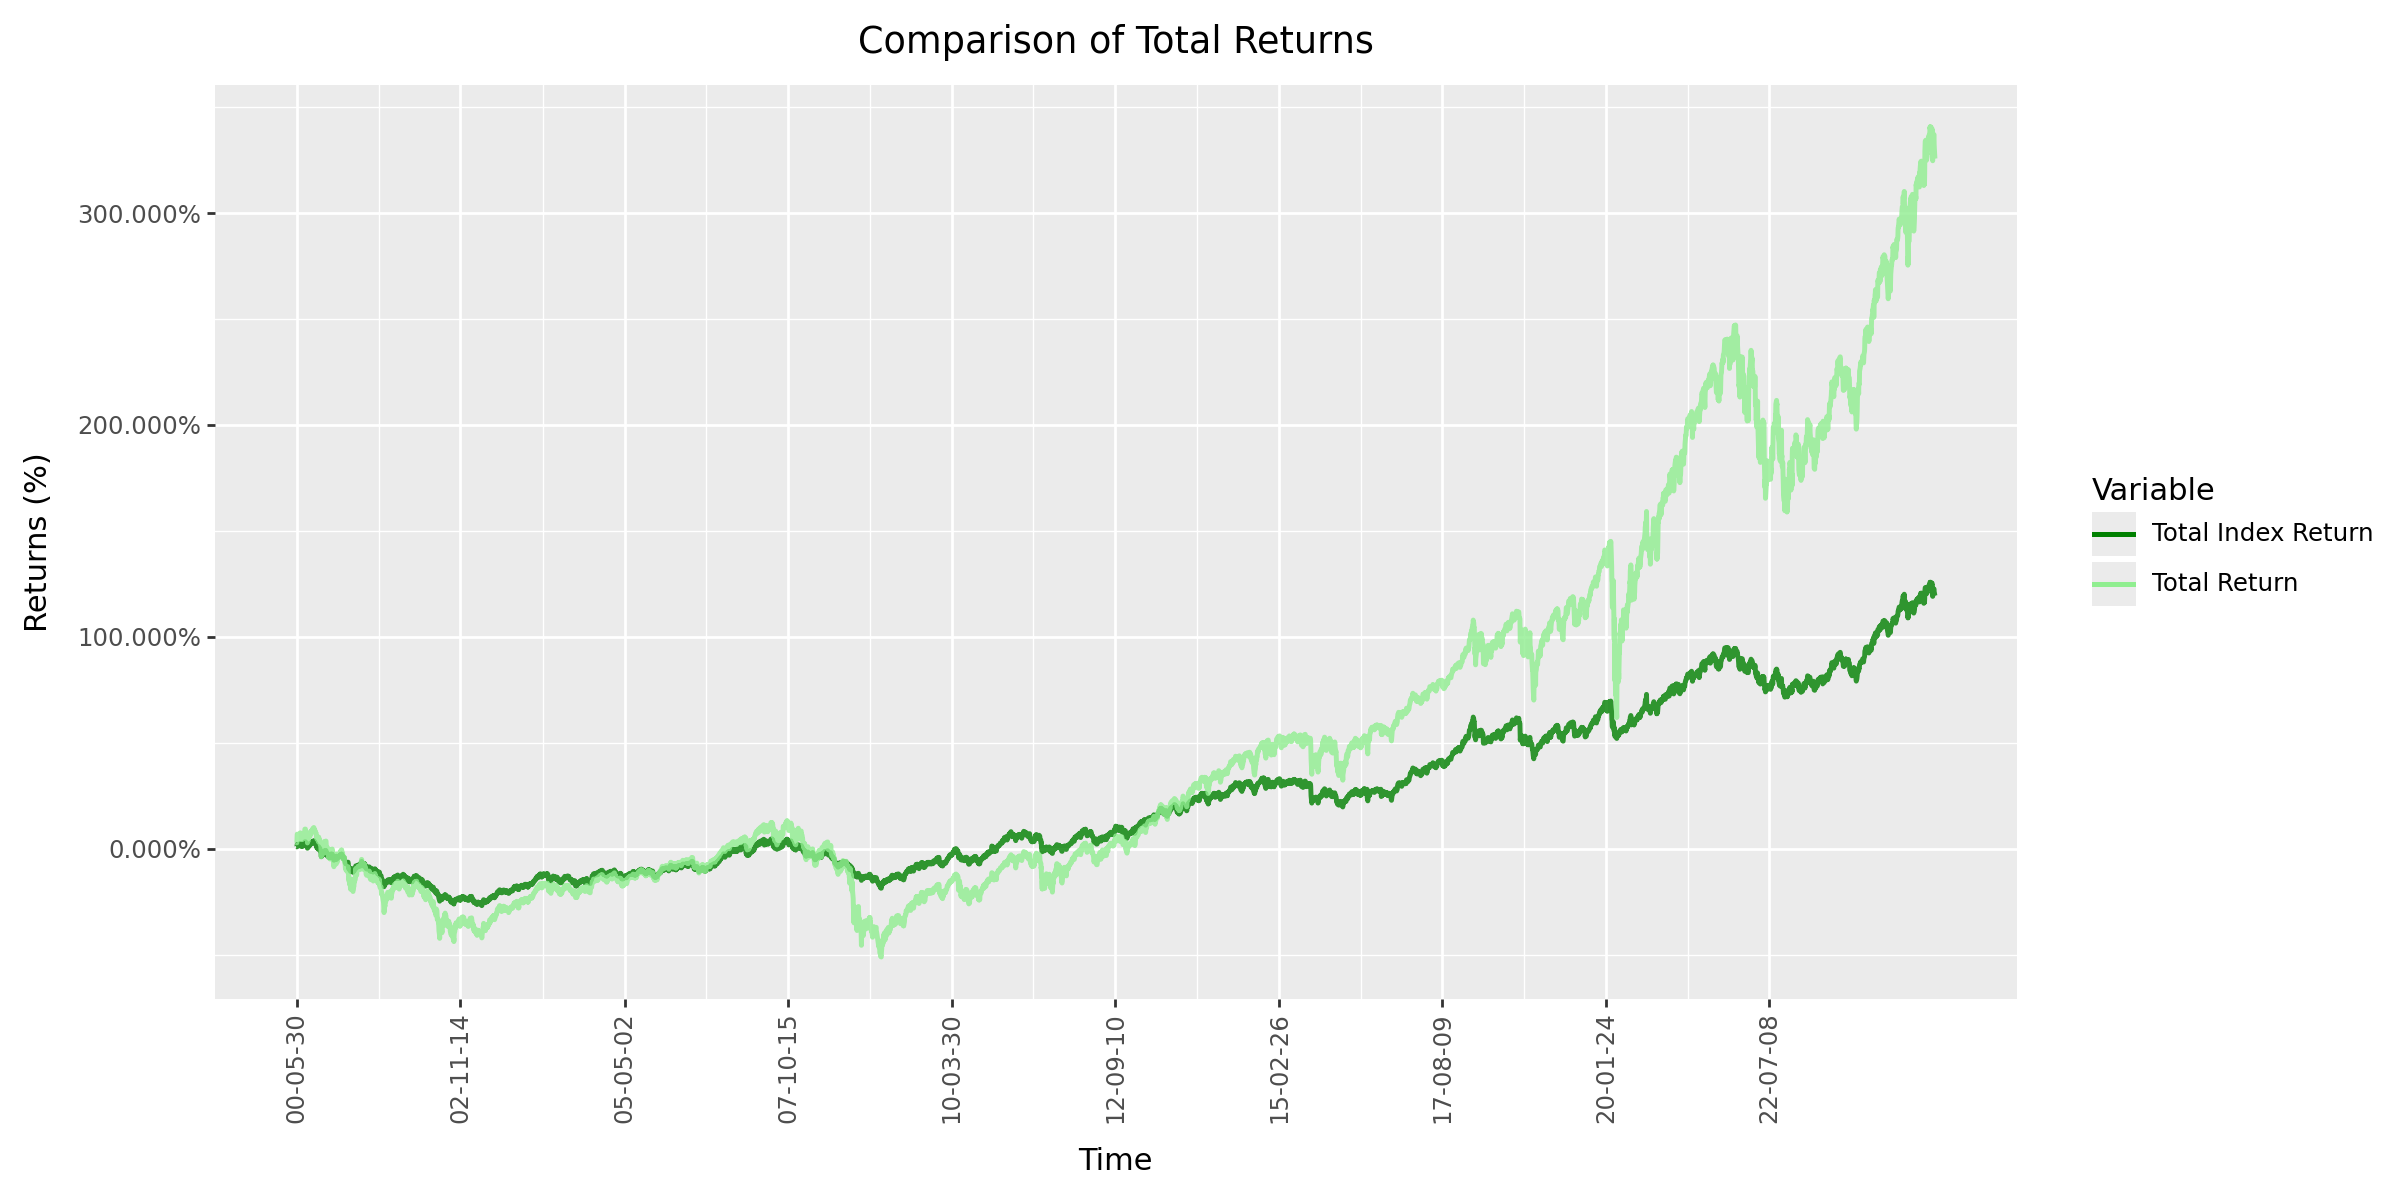

In [47]:
# now do this for the the whole period of data, but instead, get rid of the day returns and the quantiles
# get the total returns for the whole window, but instead, get rid of the day returns and the quantiles
merged_returns_2, weights_df_2 = calc_total_returns(merged_returns)

# Melt the dataframe to long format for plotting
plot_df_2 = merged_returns_2.melt(
    id_vars=['time', 'time_label'],
    value_vars=['total_return', 'total_index_return'],
    var_name='return_type',
    value_name='return_value'
)

# Plot the returns for the whole period
plot_2 = plot_returns(plot_df_2)
plot_2

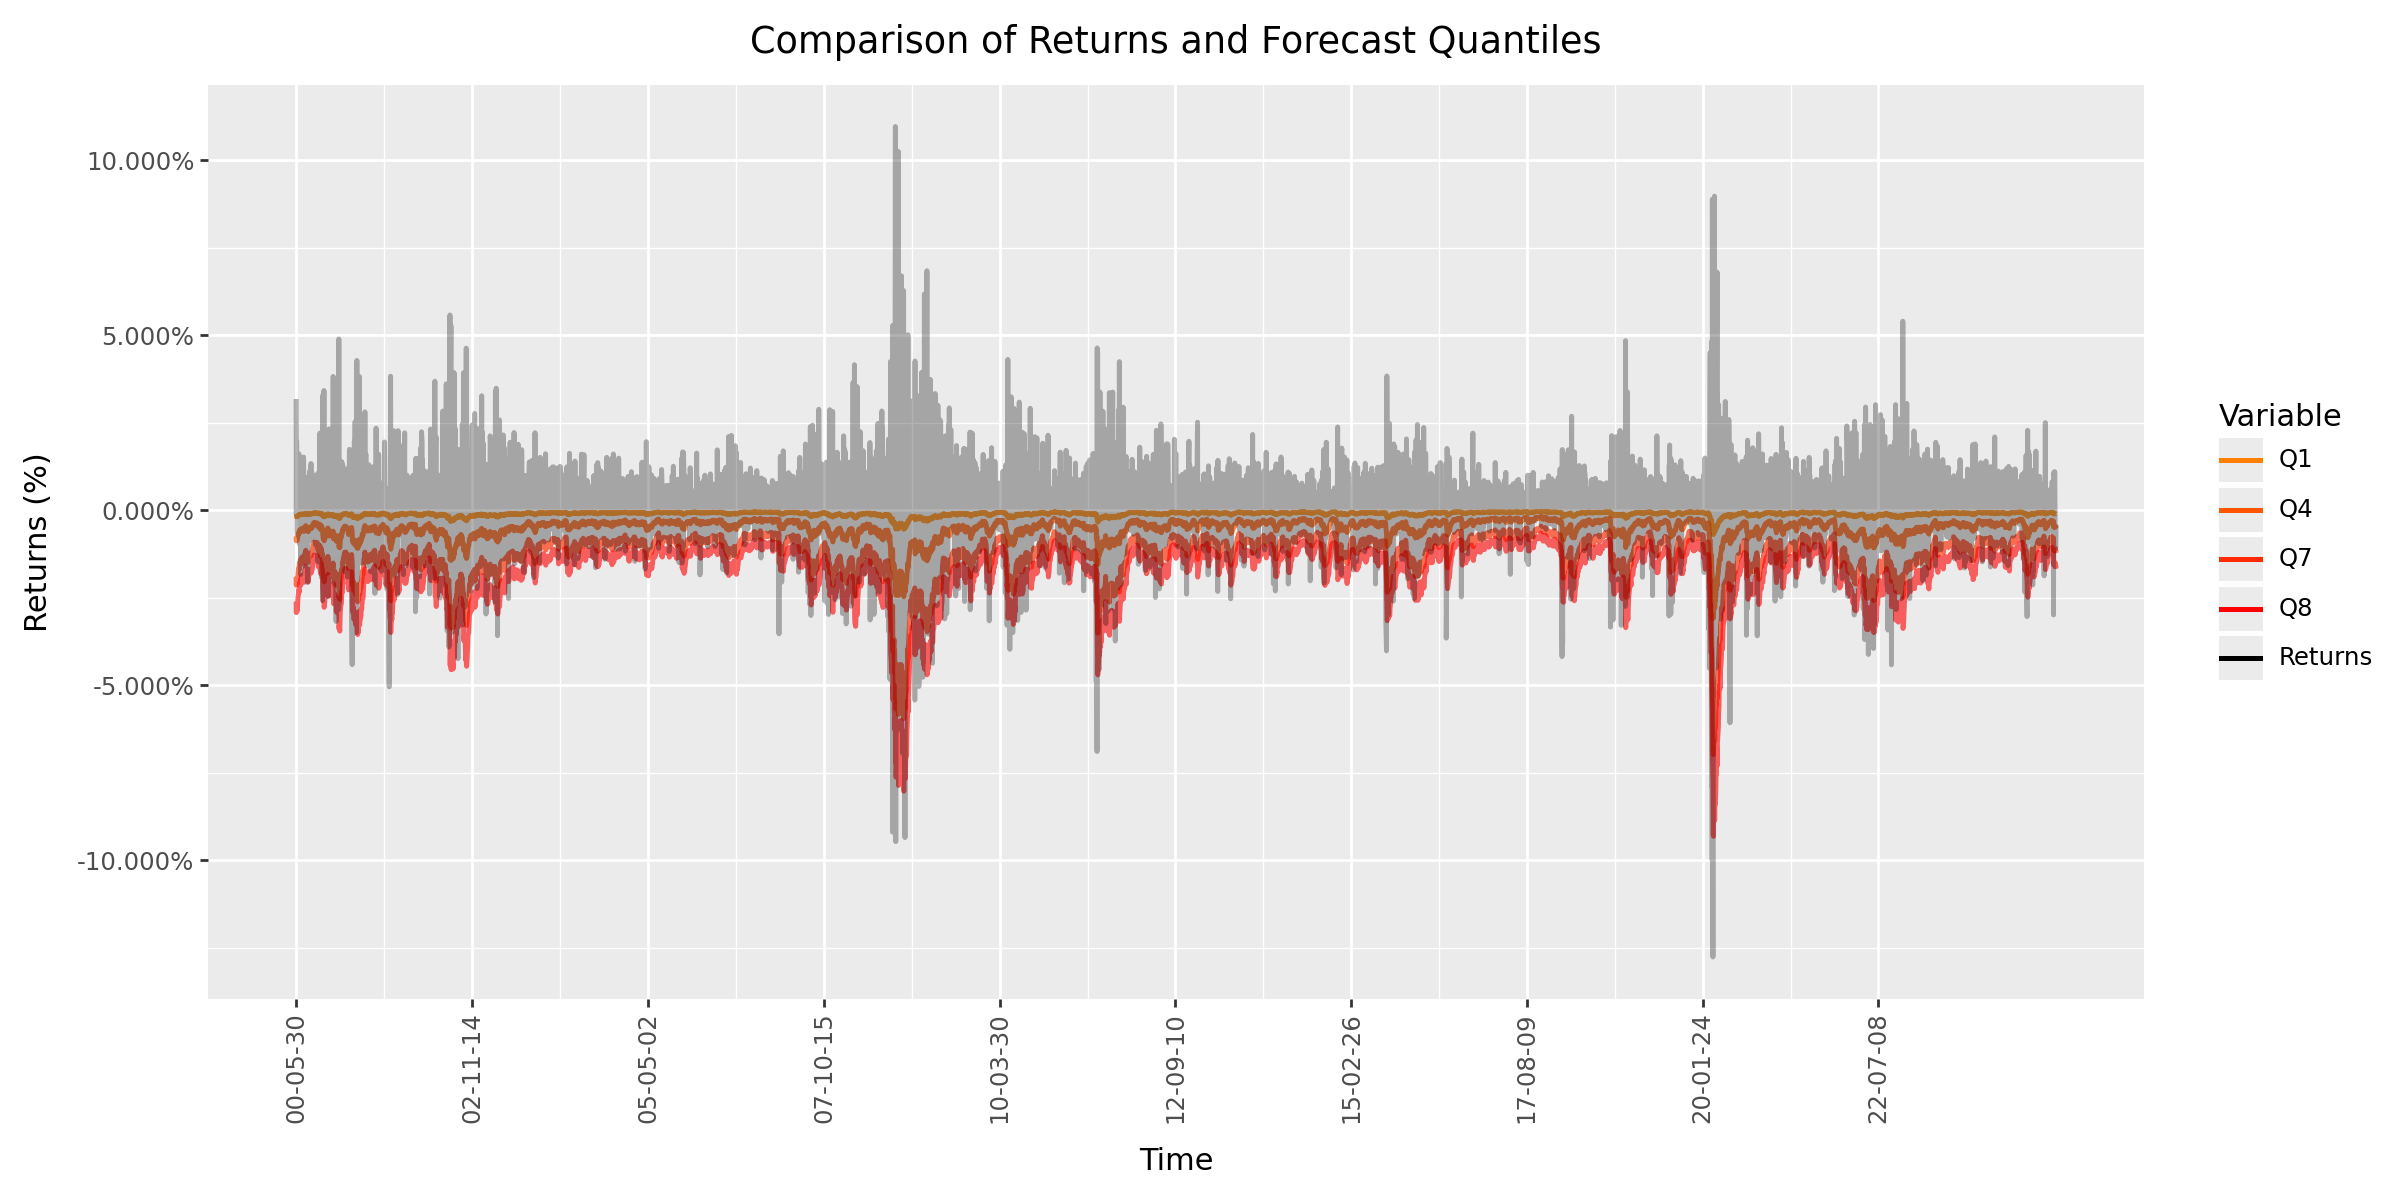

In [48]:
# just the quantiles and day returns for the whole period

# Melt the dataframe to long format for plotting
plot_df_2b = merged_returns_2.melt(
    id_vars=['time', 'time_label'],
    value_vars=['return'] + [f'q_{i}' for i in [1,4,7,8]], 
    var_name='return_type',
    value_name='return_value'
)

# Plot the returns for the whole period
plot_3 = plot_returns(plot_df_2b)
plot_3


#### During the COVID-19 Pandemic

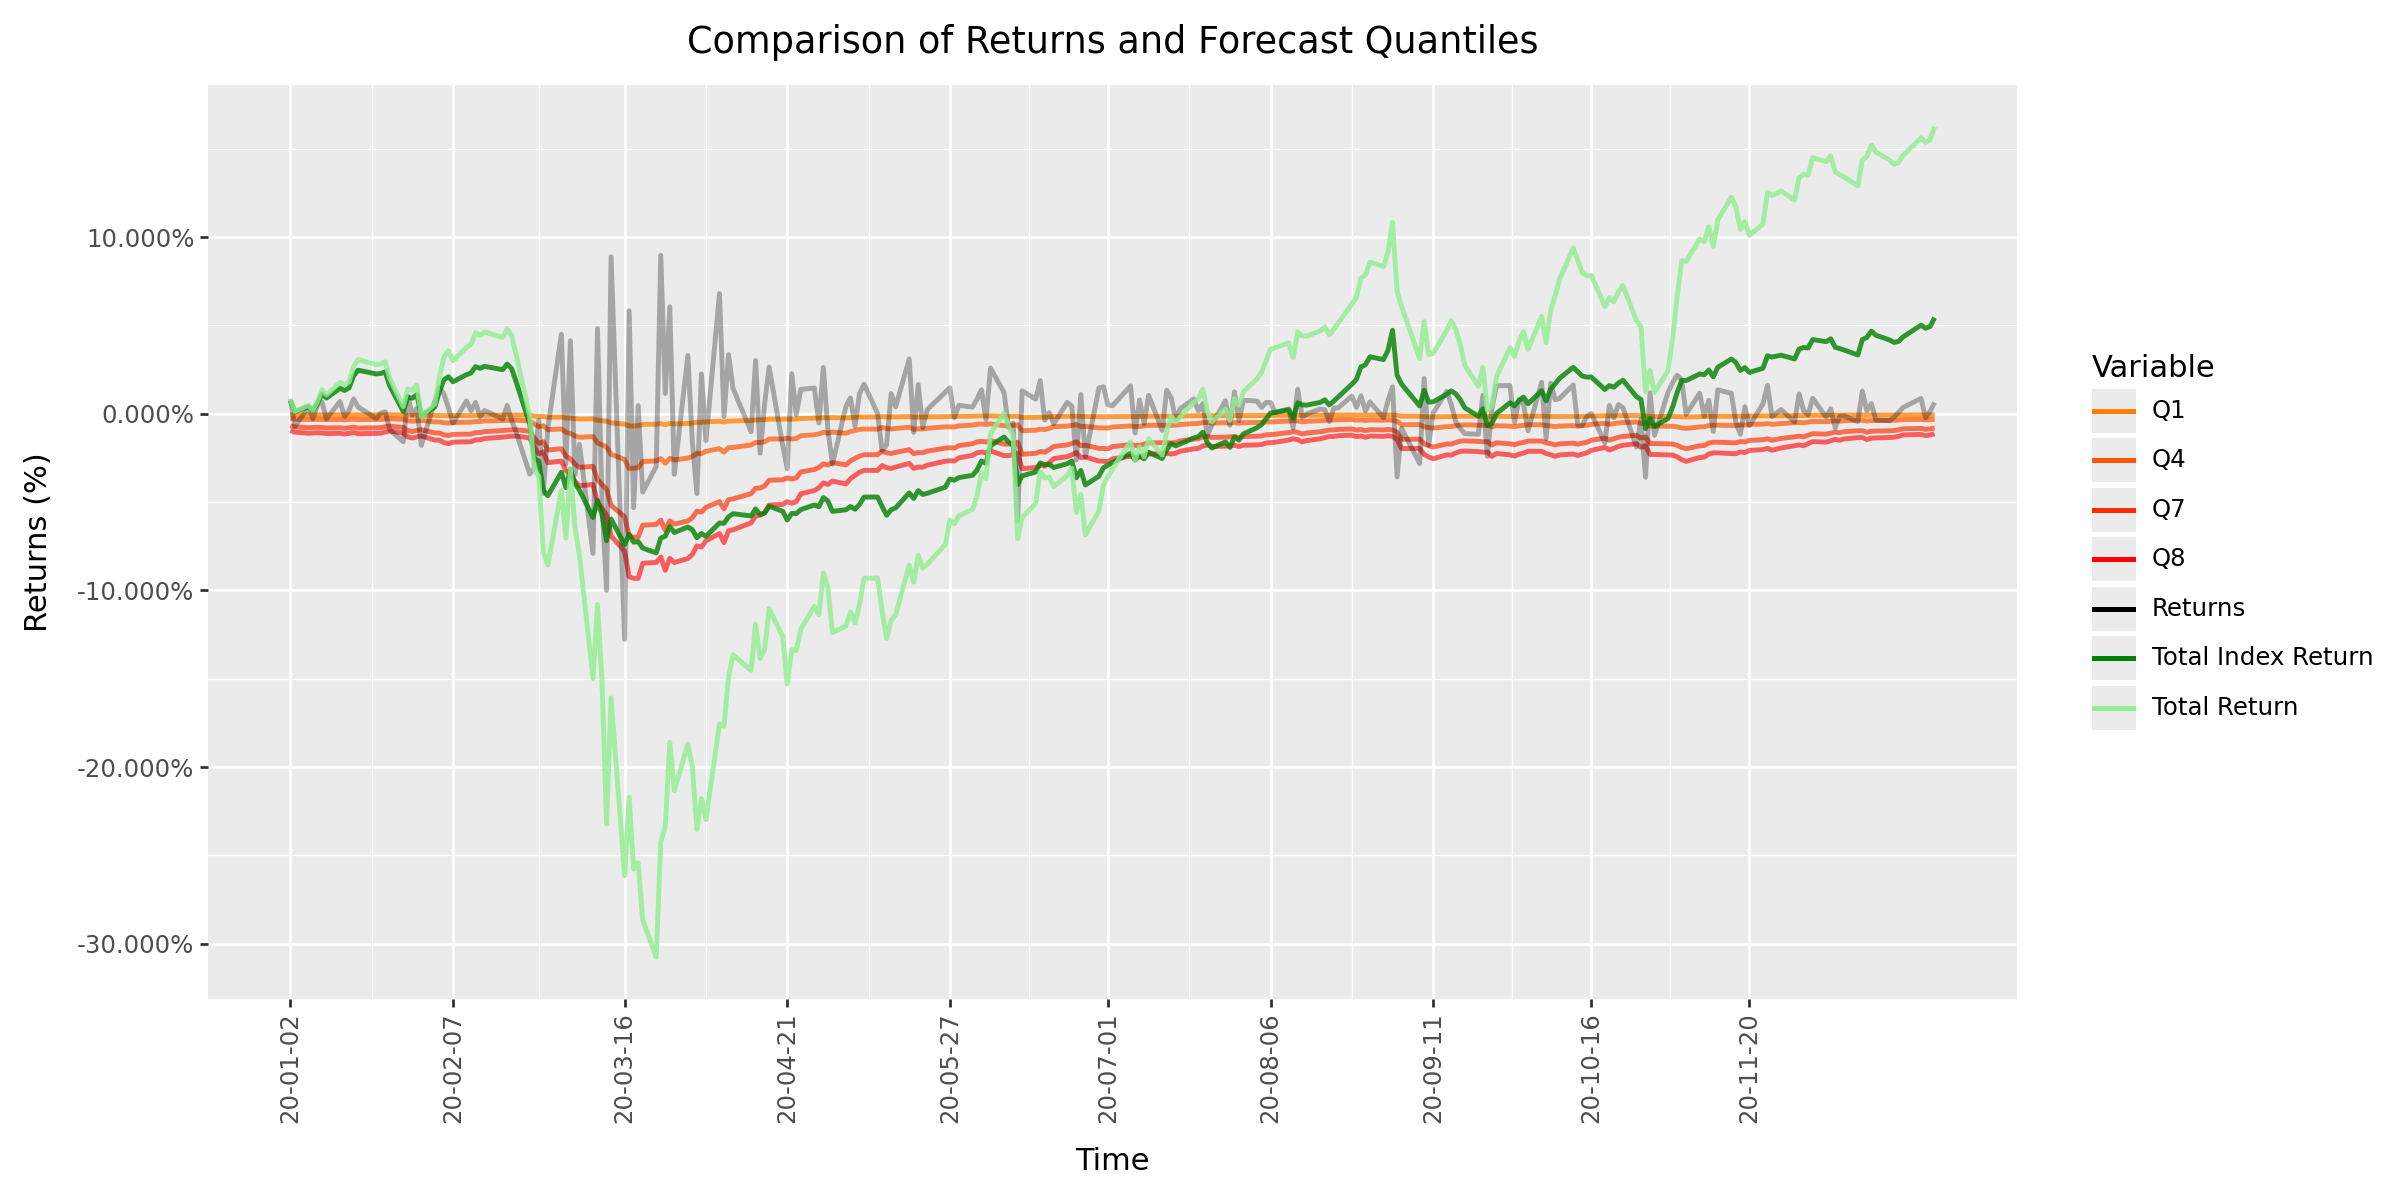

In [49]:
# Get the total returns for the COVID-19 pandemic window
# Define the pandemic window (e.g., 2020-01-01 to 2020-12-31, or adjust as needed)
merged_returns_3, weights_df_3 = calc_total_returns(merged_returns, start_date='2020-01-01', end_date='2020-12-31')

# Drop the return column and any q_i type column
#merged_returns_3 = merged_returns_3.drop(columns=['return'] + [f'q_{i}' for i in [1,4,7,8]])

# Melt the dataframe to long format for plotting
plot_df_3 = merged_returns_3.melt(
    id_vars=['time', 'time_label'],
    var_name='return_type',
    value_name='return_value'
)

# Plot the returns for the pandemic period
plot_3 = plot_returns(plot_df_3)
plot_3

### Plot the Weights Over Time

In [50]:
# Melt the weights dataframe to long format for plotting
# Use all columns except 'time' as value_vars
weights_plot = weights_df_1.melt(
    id_vars=['time', 'time_label'],
    var_name='weight_type',
    value_name='weight_value'
)

# do this for the second weights DataFrame
weights_plot_2 = weights_df_2.melt(
    id_vars=['time', 'time_label'],
    var_name='weight_type',
    value_name='weight_value'
)

In [51]:
# add a color mapping for the weights
weights_color_map = {
    'target_weight': 'blue',
    'index_weight': 'purple'
}

# add a label mapping for the weights
weights_label_map = {
    'target_weight': 'Target Weight',
    'index_weight': 'Index Weight'
}

# create a transparency/alpha mapping for the weights
weights_alpha_map = {
    'target_weight': 0.4,
    'index_weight': 0.8
}

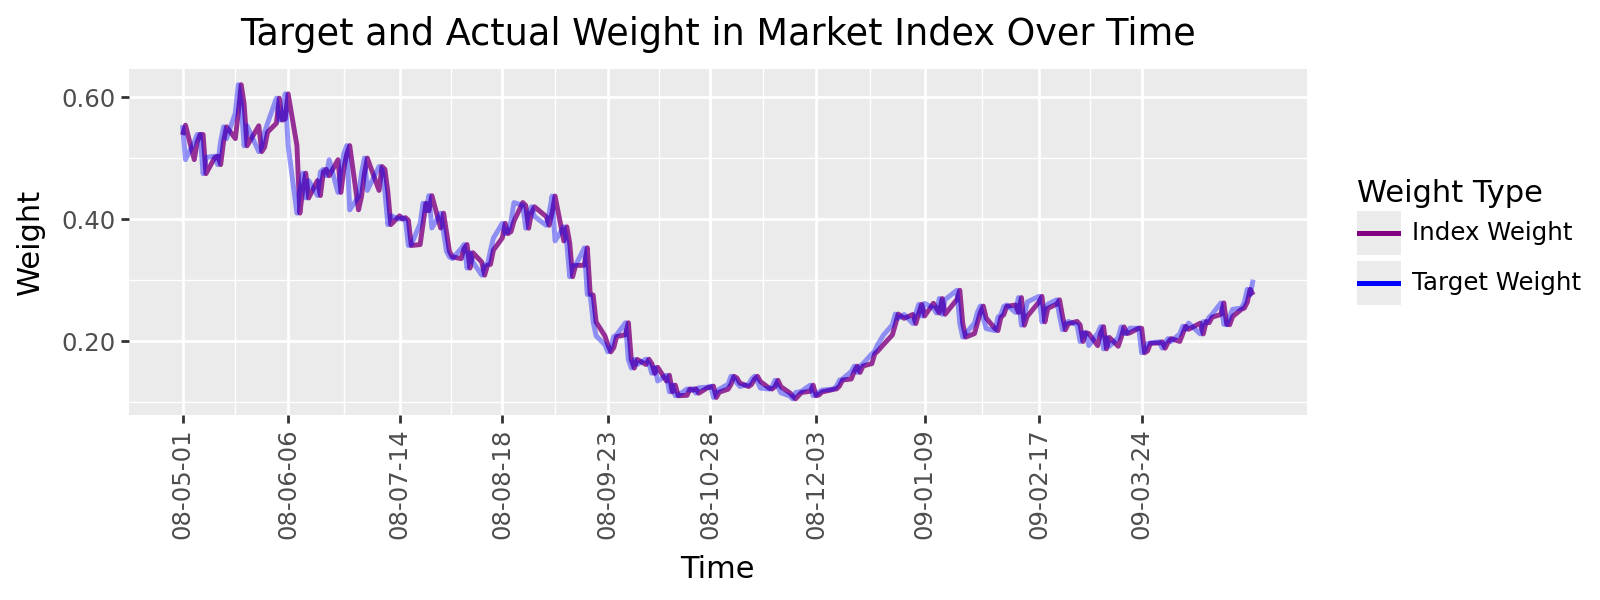

In [52]:
def plot_w(weights_plot_df):
    """
    Create a ggplot object for target and index weights over time.

    Args:
        weights_plot_df (pd.DataFrame): DataFrame in long format with columns ['time', 'time_label', 'weight_type', 'weight_value'].

    Returns:
        plotnine.ggplot.ggplot: The ggplot object (not displayed).
    """
    # Generate x-axis breaks and labels for clear date ticks
    time_breaks, time_labels = gen_x_labels(weights_plot_df)

    # Create the plot using plotnine (ggplot-style)
    plot_w_targ = (
        # Set up the basic plot with aesthetics: x=time, y=weight_value, color/alpha by weight_type
        ggplot(weights_plot_df, aes(x='time', y='weight_value', color='weight_type', alpha='weight_type')) +
        # Draw lines for each weight_type
        geom_line(size=1) +
        # Set plot and axis labels
        labs(
            title='Target and Actual Weight in Market Index Over Time',
            x='Time',
            y='Weight',
            color='Weight Type'
        ) +
        # Set transparency for each weight_type
        scale_alpha_manual(values=weights_alpha_map) +
        # Set x-axis breaks and labels for dates
        scale_x_date(breaks=time_breaks, labels=time_labels) +
        # Set colors for each weight_type and legend labels
        scale_color_manual(values=weights_color_map, labels=weights_label_map) +
        # Format y-axis to show two decimal places
        scale_y_continuous(labels=lambda l: [f"{v:.2f}" for v in l]) +
        # Customize theme: rotate x labels, center title, set figure size
        theme(
            axis_text_x=element_text(rotation=90, ha='center'),
            plot_title=element_text(ha='center'),
            figure_size=(8, 3)
        ) +
        # Remove unwanted guides from legend (hide alpha legend)
        guides(alpha=False)
    )
    return plot_w_targ

plot_w_targ = plot_w(weights_plot)
plot_w_targ

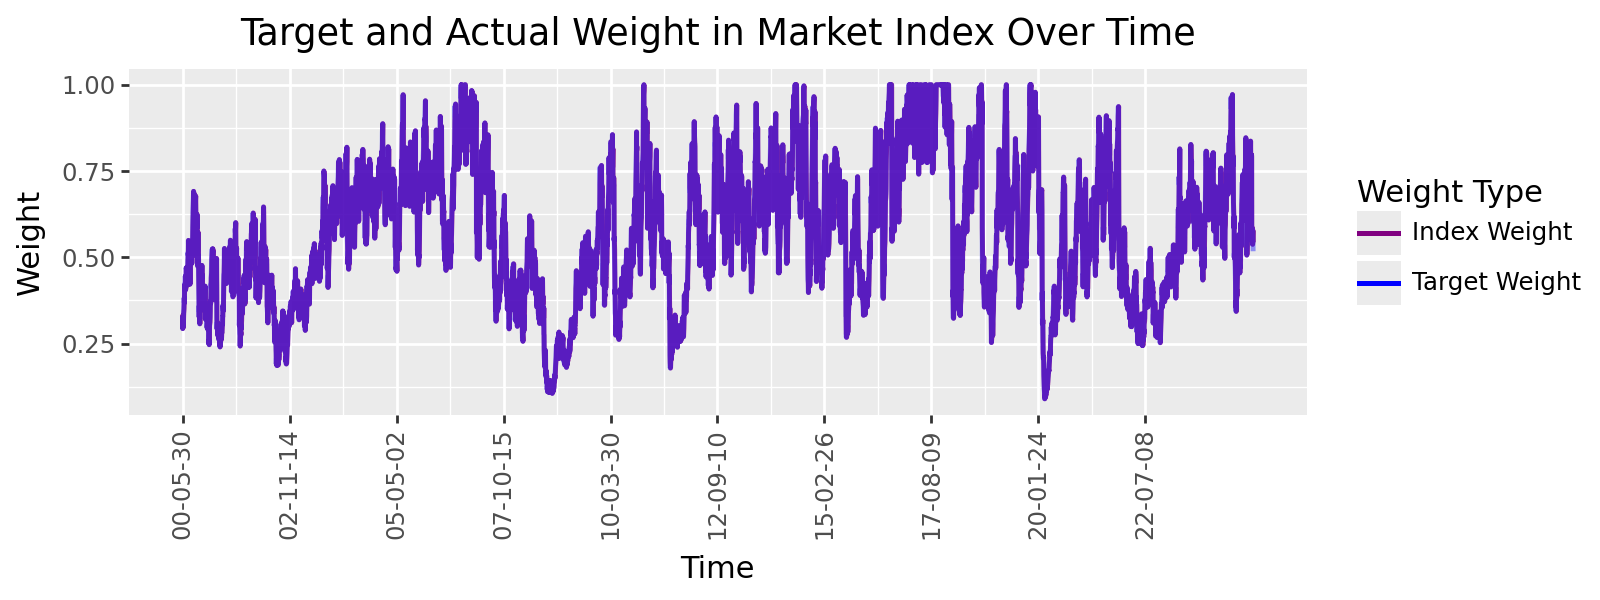

In [53]:
# do this for the second weights DataFrame
plot_w_targ_2 = plot_w(weights_plot_2)
plot_w_targ_2